# Kalman Filter for Air Quality
see also 'Optimum Linear Estimation' at https://www.sciencedirect.com/topics/social-sciences/kalman-filter

- Replaces a multiple linear regression (MLR) batch run, runs recursively on an Arduino Atmega1284P as adaprive filter for the MLR regression coefficients
- Kalman Filter is derived from https://github.com/zziz/kalman-filter
- For theory, please read https://en.wikipedia.org/wiki/Kalman_filter
- Key is to set the covariance of the process noise matrix to a zero matrix! See hint in 'Optimum Linear Estimation' at https://www.sciencedirect.com/topics/social-sciences/kalman-filter.
- I send a big thank you to those who provided these great basis contributions

## Prerequisites (only necessary if you use '%matplotlib widgets' (which doesn't work at my side yet))

- For LINUX operating systems the following software installations are necessary for getting interactive mathplotlib graphs working.
- For other operating system, please check in the internet for appropriate solutions.
- Please run the following commands from the LINUX command line (still trying to get interactive matplotlib graphs working):

> conda install conda-build<br/>
> conda init bash<br/>
> conda activate base<br/>
> conda install -c conda-forge jupyterlab ipywidgets nodejs<br/>
> pip install ipywidgets<br/>
> pip install ipympl<br/>
> conda install -y nodejs<br/>
> pip install --upgrade jupyterlab<br/>
> jupyter labextension list<br/>
> jupyter lab clean<br/>
> jupyter lab build<br/>
> jupyter labextension install @8080labs/qgrid<br/>
> jupyter labextension install @jupyter-widgets/jupyterlab-manager<br/>
> jupyter labextension install jupyterlab-python-file<br/>
> jupyter labextension install jupyter-matplotlib<br/>
> jupyter nbextension enable --py widgetsnbextension<br/>
> jupyter labextension list<br/>



## Basic Kalman Filter class from https://github.com/zziz/kalman-filter:

In [1]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)             # Predicted (a priori) state estimate
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q      # Predicted (a priori) estimate covariance
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)                                  # Innovation or measurement pre-fit residual
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))           # Innovation (or pre-fit residual) covariance
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))          # Optimal Kalman gain
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T) # Updated (a posteriori) estimate covariance 

## Read historian.csv (same input file as 'Multiple linear regression for BME680 gas readings of a single sensor.ipynb' is using

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from datetime import datetime

import numpy as np


dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S.%f')
  
df = pd.read_csv("historian.csv", sep=';', decimal=".", skiprows = [0,1,2],dtype={'High': np.float64, 'Low': np.float64}, header = None, encoding= 'unicode_escape',  parse_dates=[0], date_parser=dateparse, names = [ 'Datum', 'Mode', 'raw_gas_resistance', 'relative_humidity', 'temperature'])

df['raw_gas_resistance'] *= 1000.0

# print first 5 lines of the pandas dataframe

df.head()


,Datum,Mode,raw_gas_resistance,relative_humidity,temperature
0,2020-12-11 10:37:06.000,2,65540.0,31.3,22.424
1,2020-12-11 10:38:08.486,2,65540.0,31.3,22.400
2,2020-12-11 10:38:08.490,2,65540.0,31.8,22.400
3,2020-12-11 10:38:08.496,2,65700.0,31.8,22.400
4,2020-12-11 10:42:33.794,2,65700.0,31.8,22.500


Print values of Pandas dataframe. Please x-check if they meet your expectation!

In [3]:
df.values

array([[Timestamp('2020-12-11 10:37:06'), 2, 65540.0, 31.3, 22.424],
       [Timestamp('2020-12-11 10:38:08.486000'), 2, 65540.0, 31.3, 22.4],
       [Timestamp('2020-12-11 10:38:08.490000'), 2, 65540.0, 31.8, 22.4],
       ...,
       [Timestamp('2020-12-16 09:33:14.646000'), 2, 46040.0, 38.6, 25.0],
       [Timestamp('2020-12-16 09:33:14.651000'), 2, 46860.0, 38.6, 25.0],
       [Timestamp('2020-12-16 09:37:06'), 2, 46860.0, 38.6, 24.711]],
      dtype=object)

## Formulas for calculating the absolute humidity

In [4]:
import numpy as np
# Create a function that  calculates the absolute humidity from the two arguments 'temperature' and 'relative humidity'
# see for details https://www.kompf.de/weather/vent.html or  https://rechneronline.de/barometer/luftfeuchtigkeit.php for x-checking the calculated result

a = 6.112
b = 17.67
c = 243.5

# Compute saturated water vapor pressure in hPa
# Param t - temperature in °C
def svp(t):
  svp = a * np.exp((b*t)/(c+t))
  return svp

# Compute actual water vapor pressure in hPa
# Param rh - relative humidity in %
# Param t - temperature in °C
def vp(rh, t):
  vp = rh/100. * svp(t)
  return vp

# Compute the absolute humidity in g/m³
# Param rh - relative humidity in %
# Param t - temperature in °C
def calculate_absolute_humidity(t, rh):
  mw = 18.016 # kg/kmol (Molekulargewicht des Wasserdampfes)
  rs = 8314.3 # J/(kmol*K) (universelle Gaskonstante)
  ah = 10**5 * mw/rs * vp(rh, t)/(t + 273.15)
  #return the absolute humidity in [g/m³]
  return ah

# now apply the above defined formulas to get the pandas dataframe column 'absolute_humidity'
df['absolute_humidity'] = calculate_absolute_humidity(df['temperature'], df['relative_humidity'])

## Plot the calculated absolute humidity

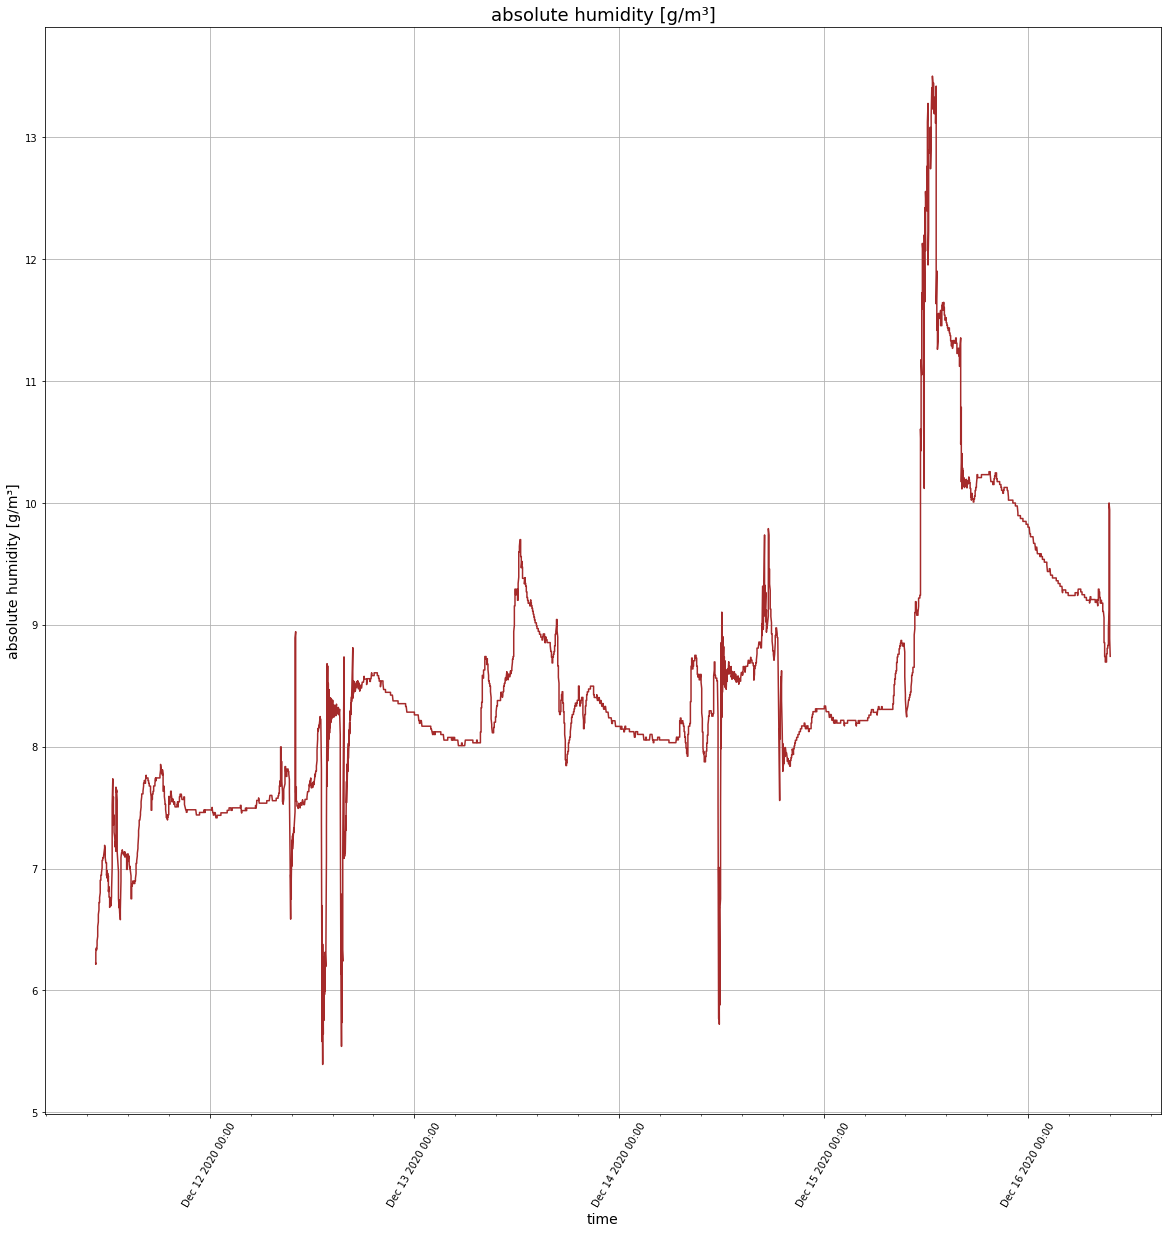

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

fig, ax = plt.subplots(figsize=(20, 20))
plt.xticks(rotation=60)
ax.xaxis.set_major_formatter(DateFormatter('%b %d %Y %H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.plot_date(df['Datum'], df['absolute_humidity'], linestyle='solid', marker=" ", color='brown')         
plt.title('absolute humidity [g/m³]', fontsize=18)
plt.xlabel('time', fontsize=14)
plt.ylabel('absolute humidity [g/m³]', fontsize=14)
plt.grid(True)
plt.show()

Print again the first 5 lines of the Pandas dataframe. Check if a column for the absolute humidity has been added.

In [6]:
df.head()

,Datum,Mode,raw_gas_resistance,relative_humidity,temperature,absolute_humidity
0,2020-12-11 10:37:06.000,2,65540.0,31.3,22.424,6.223026
1,2020-12-11 10:38:08.486,2,65540.0,31.3,22.400,6.214449
2,2020-12-11 10:38:08.490,2,65540.0,31.8,22.400,6.313721
3,2020-12-11 10:38:08.496,2,65700.0,31.8,22.400,6.313721
4,2020-12-11 10:42:33.794,2,65700.0,31.8,22.500,6.350098


Create a subset of the measurement data: 'raw_gas_resistance','temperature','absolute_humidity'

In [7]:
my_observations = df[['raw_gas_resistance','temperature','absolute_humidity']] 
my_observations.head()

,raw_gas_resistance,temperature,absolute_humidity
0,65540.0,22.424,6.223026
1,65540.0,22.400,6.214449
2,65540.0,22.400,6.313721
3,65700.0,22.400,6.313721
4,65700.0,22.500,6.350098


Create a numpy array of measurements for further processing

In [8]:
list_of_rows = [list(row) for row in my_observations.values]

Print the first four elements of list of lists i.e. rows

In [9]:
print(list_of_rows[:4])

[[65540.0, 22.424, 6.223025819874211], [65540.0, 22.4, 6.21444896596281], [65540.0, 22.4, 6.313721313661896], [65700.0, 22.4, 6.313721313661896]]


Convert the selection of measurements to a numpy array

In [10]:
np.array(list_of_rows)
measurements = np.array(list_of_rows)
print("number of measurement datapoints = ", len(measurements))

number of measurement datapoints =  4763


## Set the parameters of the Kalman filter

- Kalman filter with a zero covariance matrix for the process noise is well known a the recursive minimum least-square error (LMMSE) filter for a linear system with some assumptions on auto- and cross-correlations of process and measurement noise and initial state.

- observation vector y                         :   [raw_gas_resistance]; n=1; note: 'temperature' and 'aH' are NOT part of the observation vector! 
- system state vector X                        :   [VOC_resistance, alpha_temperature, beta_ah, delta_intercept]; m=4
- state transition matrix F                    :   identity matrix (m, n)
- observation transition matrix H              :   initial identidy matrix (1,m); then set to state dependant
- covariance matrix of the process noise Q     :   zero matrix (m,m)
- covariance matrix of the observation noise R :   matrix(1,1) with very small value

In [11]:
F = np.eye(4)
H = np.array([ [1, 1, 1, 1] ]).reshape(1, 4)
# key ist to set Q to a zero matrix, in this case the Kalman filter works an ordinary least squares minimizer filter
Q = np.array([ [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0] ]).reshape(4, 4)
# set covariance of gast resistance measurements also to a very small value
R = np.array([ [0.01] ]).reshape(1, 1)

print("\nF = ",F)  # the state-transition model;
print("\nInitial H = ",H)  # the observation model;
print("\nQ = ",Q)  # covariance of the process noise
print("\nR = ",R)  # covariance of the observation noise



F =  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Initial H =  [[1 1 1 1]]

Q =  [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]

R =  [[0.01]]


## Initialize the Kalman filter

In [12]:
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []
states=[]

print("raw gas resistance measurements =", measurements[:,0])

print("dim measurements : ", measurements.shape)

last_index = len(measurements)

print ("last index of measurement array = ", last_index)



raw gas resistance measurements = [65540. 65540. 65540. ... 46040. 46860. 46860.]
dim measurements :  (4763, 3)
last index of measurement array =  4763


## Run the Kalman filter

In [13]:
it = 0  # iteration index
for z in measurements:
    zg = z[0]
    # make observation model matrix state dependant
    H = np.array([[1, z[1], z[2], 1]]).reshape(1, 4)
    kf.H = H
    it = it + 1
    #print results for the last sample of the measurement sequence
    if ((it == last_index)):  # print results of last measurement index 
        print ("\nIteration index = ", it)
        print ("\n")
        print("\nState vector kf.x= ", kf.x)
        print("\nObservation vetor z = ", z)
        print("\nObservation transistion matrix kf.H = ", kf.H)
        print("\nKalman filter prediction = ", kf.predict())
        print("\nKalman filter update = ",np.dot(H,  kf.predict()))
        print ("\n\n")
    predictions.append(np.dot(H,  kf.predict()))
    states.append(kf.x)
    kf.update(zg)


Iteration index =  4763



State vector kf.x=  [[35802.29831187]
 [  762.53851154]
 [-5220.86496175]
 [35802.29831326]]

Observation vetor z =  [4.68600000e+04 2.47110000e+01 8.74207253e+00]

Observation transistion matrix kf.H =  [[ 1.         24.711       8.74207253  1.        ]]

Kalman filter prediction =  [[35802.29831187]
 [  762.53851154]
 [-5220.86496175]
 [35802.29831326]]

Kalman filter update =  [[44806.50560167]]





## Plot the results of the Kalman filter

### Plot measured gas resistance versus corrected gas resistance (compensation of temperature and humidity interference)

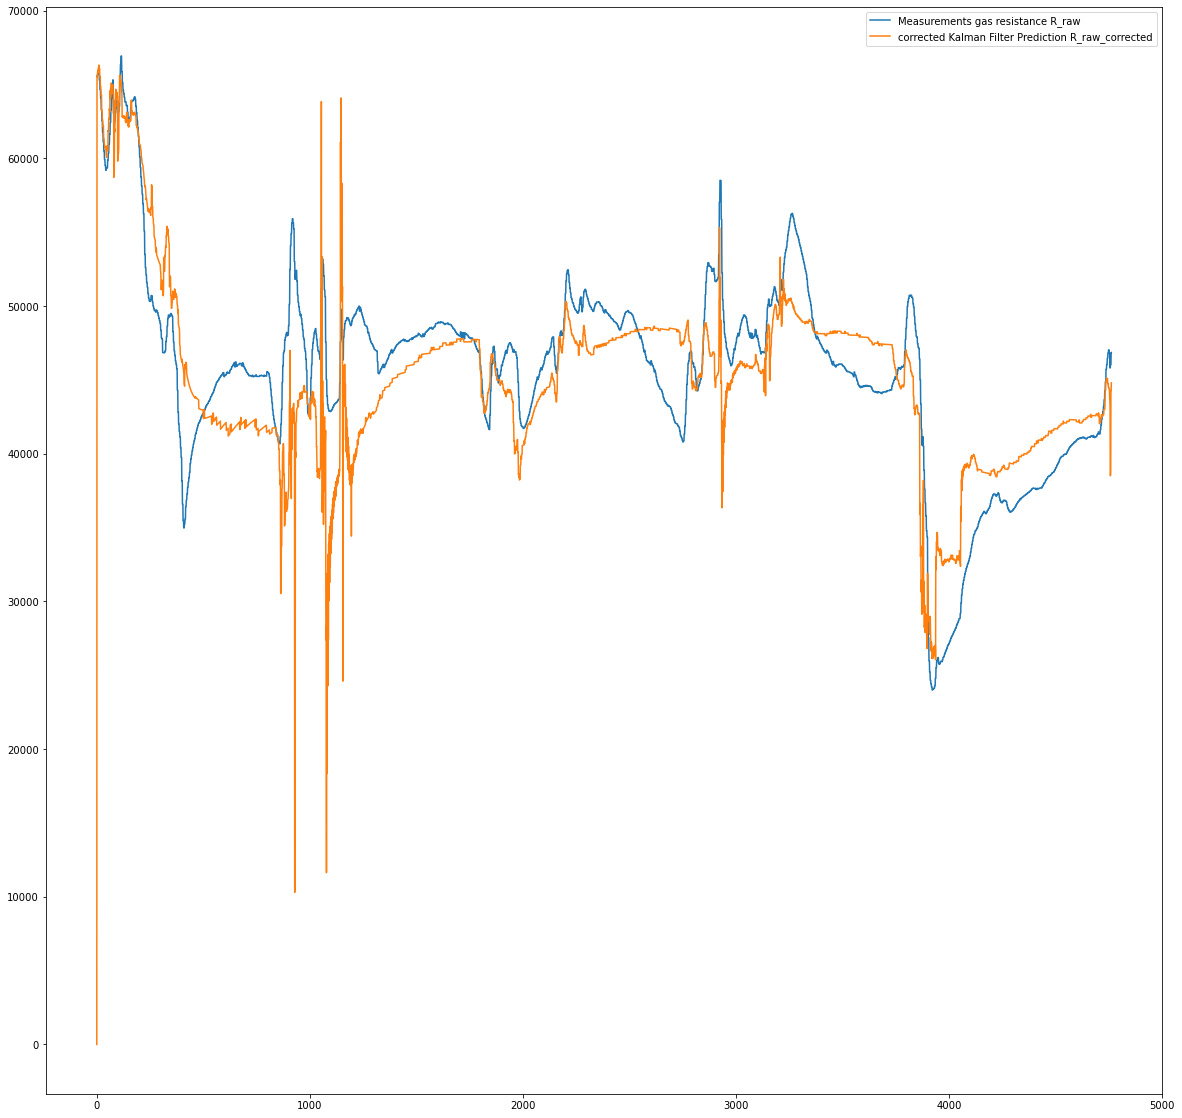

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
plt.plot(range(len(measurements)), measurements[:,0], label = 'Measurements gas resistance R_raw')
plt.plot(range(len(predictions)), np.array(predictions)[:,0], label = 'corrected Kalman Filter Prediction R_raw_corrected')#
plt.legend()
plt.show()

## Plot alpha (temperature coefficient) and beta (aH coefficient) regression coefficients

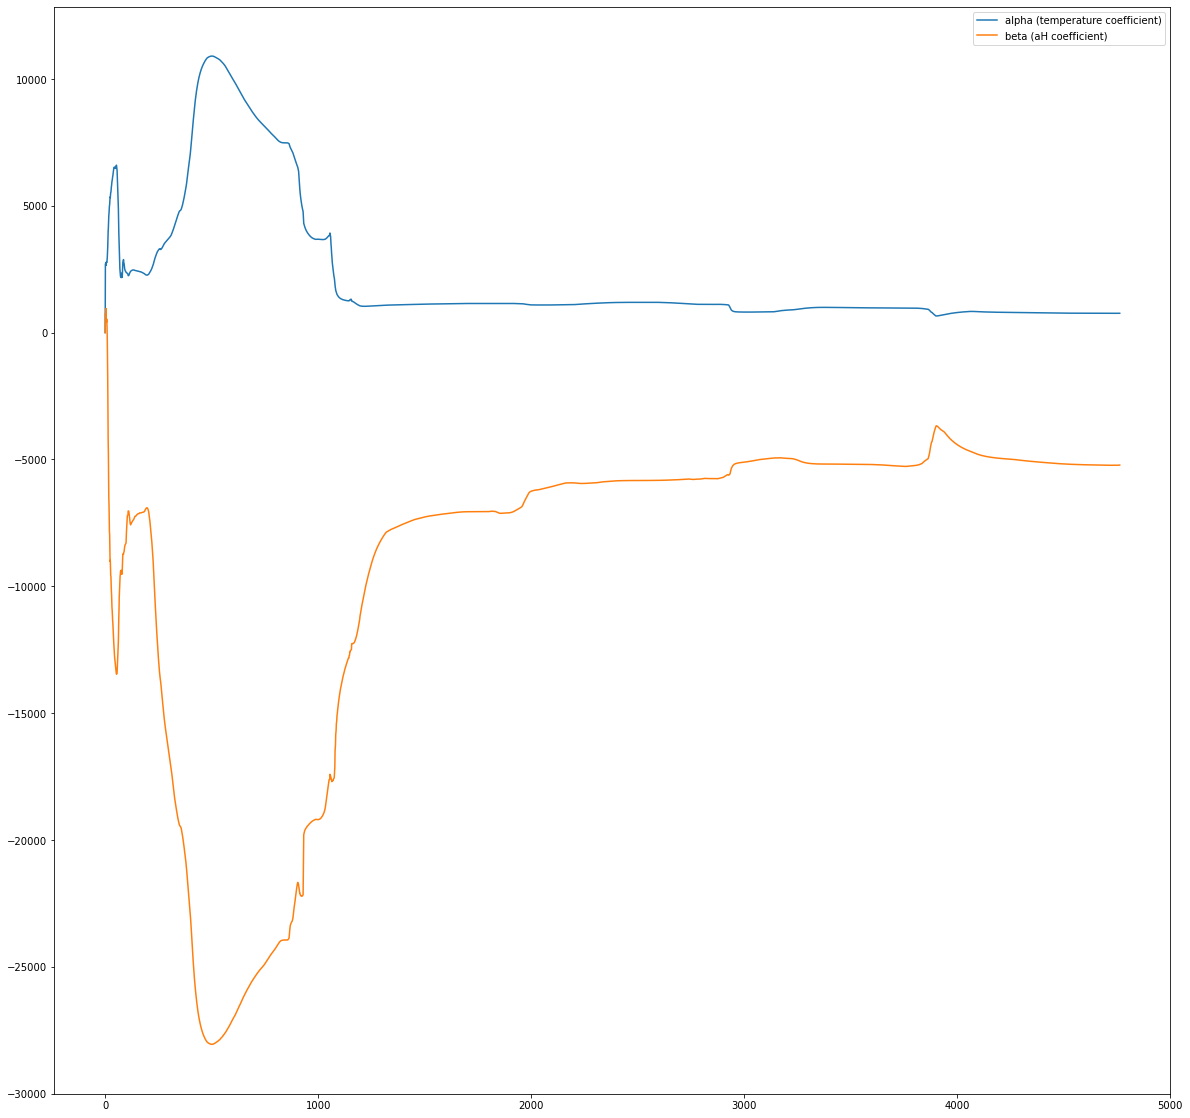

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
plt.plot(range(len(predictions)), np.array(states)[:,1], label = 'alpha (temperature coefficient)')
plt.plot(range(len(predictions)), np.array(states)[:,2], label = 'beta (aH coefficient)')
plt.legend()
plt.show()


## Plot R_gas_orrected and delta regression parameters (are identical)

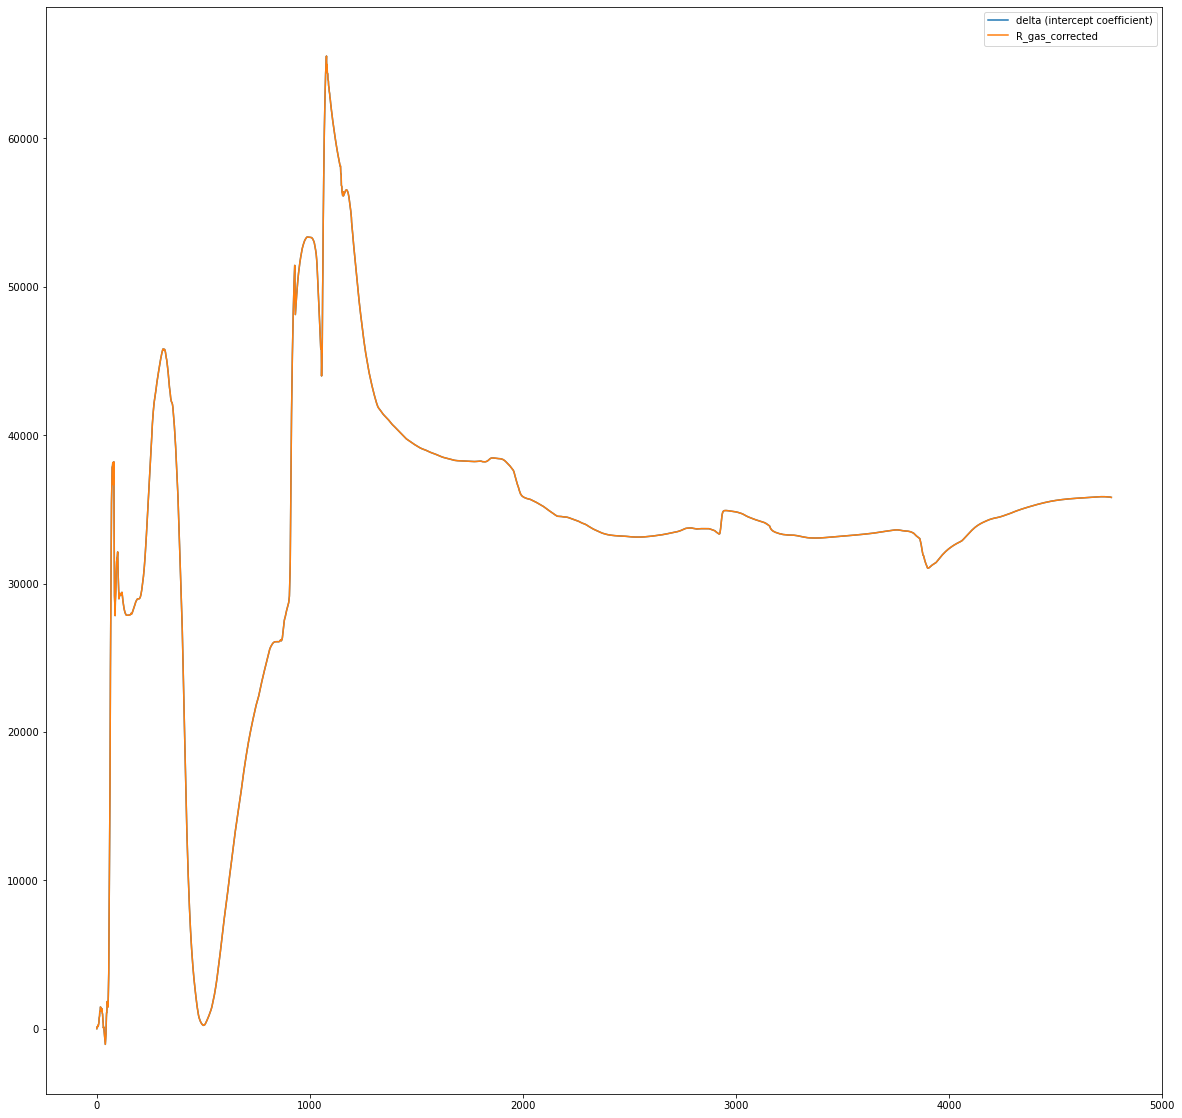

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
plt.plot(range(len(predictions)), np.array(states)[:,3], label = 'delta (intercept coefficient)')
plt.plot(range(len(predictions)), np.array(states)[:,0], label = 'R_gas_corrected')
plt.legend()
plt.show()

# Regression results of the recursive minimum least-square error (LMMSE) Kalman filter

In [17]:
print("\n\nLinear regression coefficient of temperature interference alpha_LMMSE      = ", kf.predict()[1][0])
print("Linear regression coefficient of absolute humidity interference beta_LMMSE = ", kf.predict()[2][0])
print("Linear regression intercept delta_LMMSE                                    = ", kf.predict()[0][0]+ kf.predict()[3][0])
print("\n\n")



Linear regression coefficient of temperature interference alpha_LMMSE      =  762.5881376466392
Linear regression coefficient of absolute humidity interference beta_LMMSE =  -5220.789269025093
Linear regression intercept delta_LMMSE                                    =  71603.18120473193





# You are done! Congratulations!